In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt

def process_results_file(file_path, model_name, num_rows=15):
    """
    Process a results file for a given model.
    
    This function extracts device info (CPU, GPU, Memory) from the top of the file
    and processes the file lines to collect metrics for the first 'num_rows' rows
    where "Predictions per frame" equals 1.00.
    
    It returns a dictionary with:
      - model: Model name
      - device_info: Dict with keys "CPU", "GPU", "Memory"
      - rows_considered: Number of rows used (up to num_rows)
      - mean_max_fps, median_max_fps, mean_min_fps, median_min_fps,
        mean_avg_fps, median_avg_fps, mean_pps, median_pps.
      - Raw lists: max_fps_list, min_fps_list, avg_fps_list, pps_list (for later plotting)
    """
    # Initialize device info dictionary
    device_info = {"CPU": None, "GPU": None, "Memory": None}
    
    # Lists for performance metrics
    max_fps_list = []
    min_fps_list = []
    avg_fps_list = []
    pps_list = []
    
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    # Extract device info (assuming these lines appear near the top)
    for line in lines:
        if "CPU:" in line:
            device_info["CPU"] = line.strip()
        elif "GPU:" in line:
            device_info["GPU"] = line.strip()
        elif "Memory:" in line:
            device_info["Memory"] = line.strip()
    
    # Regex pattern to capture the performance metrics
    pattern = re.compile(
        r"Max FPS:\s*([\d\.]+),\s*Min FPS:\s*([\d\.]+),\s*Avg FPS:\s*([\d\.]+),\s*Predictions per frame:\s*([\d\.]+),\s*PPS:\s*([\d\.]+)"
    )
    
    # Process lines to capture metrics for the first num_rows with Predictions per frame == 1.00
    for line in lines:
        match = pattern.search(line)
        if match:
            max_fps = float(match.group(1))
            min_fps = float(match.group(2))
            avg_fps = float(match.group(3))
            pred_frame = float(match.group(4))
            pps = float(match.group(5))
            
            if pred_frame == 1.00:
                max_fps_list.append(max_fps)
                min_fps_list.append(min_fps)
                avg_fps_list.append(avg_fps)
                pps_list.append(pps)
                
                if len(max_fps_list) == num_rows:
                    break
                    
    if not max_fps_list:
        print(f"No rows with Predictions per frame equal to 1.00 were found in {file_path}")
        return None
    
    # Compute statistics
    result = {
        "model": model_name,
        "device_info": device_info,
        "rows_considered": len(max_fps_list),
        "mean_max_fps": np.mean(max_fps_list),
        "median_max_fps": np.median(max_fps_list),
        "mean_min_fps": np.mean(min_fps_list),
        "median_min_fps": np.median(min_fps_list),
        "mean_avg_fps": np.mean(avg_fps_list),
        "median_avg_fps": np.median(avg_fps_list),
        "mean_pps": np.mean(pps_list),
        "median_pps": np.median(pps_list),
        "max_fps_list": max_fps_list,
        "min_fps_list": min_fps_list,
        "avg_fps_list": avg_fps_list,
        "pps_list": pps_list
    }
    
    # Print out summary for this model
    print(f"Model: {model_name}")
    print("Device Info:")
    for k, v in device_info.items():
        print(f"  {k}: {v}")
    print(f"Rows considered: {result['rows_considered']}")
    print(f"Mean Max FPS: {result['mean_max_fps']:.2f}, Median Max FPS: {result['median_max_fps']:.2f}")
    print(f"Mean Min FPS: {result['mean_min_fps']:.2f}, Median Min FPS: {result['median_min_fps']:.2f}")
    print(f"Mean Avg FPS: {result['mean_avg_fps']:.2f}, Median Avg FPS: {result['median_avg_fps']:.2f}")
    print(f"Mean PPS: {result['mean_pps']:.2f}, Median PPS: {result['median_pps']:.2f}")
    
    # (Optional) Draw diagrams for this model alone:
    # Grouped bar chart for Mean vs. Median for each metric:
    metrics = ["Max FPS", "Min FPS", "Avg FPS", "PPS"]
    mean_values = [result["mean_max_fps"], result["mean_min_fps"], result["mean_avg_fps"], result["mean_pps"]]
    median_values = [result["median_max_fps"], result["median_min_fps"], result["median_avg_fps"], result["median_pps"]]
    
    x = np.arange(len(metrics))
    width = 0.35
    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, mean_values, width, label="Mean", color="skyblue")
    plt.bar(x + width/2, median_values, width, label="Median", color="salmon")
    plt.xticks(x, metrics)
    plt.ylabel("Value")
    plt.title(f"Mean vs. Median for {model_name} (First {num_rows} Rows)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Histograms for each metric (optional):
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    axs = axs.flatten()
    axs[0].hist(result["max_fps_list"], bins=10, color="mediumseagreen", edgecolor="black")
    axs[0].set_title("Max FPS Distribution")
    axs[0].set_xlabel("Max FPS")
    axs[0].set_ylabel("Frequency")
    axs[1].hist(result["min_fps_list"], bins=10, color="mediumpurple", edgecolor="black")
    axs[1].set_title("Min FPS Distribution")
    axs[1].set_xlabel("Min FPS")
    axs[1].set_ylabel("Frequency")
    axs[2].hist(result["avg_fps_list"], bins=10, color="lightcoral", edgecolor="black")
    axs[2].set_title("Avg FPS Distribution")
    axs[2].set_xlabel("Avg FPS")
    axs[2].set_ylabel("Frequency")
    axs[3].hist(result["pps_list"], bins=10, color="darkorange", edgecolor="black")
    axs[3].set_title("PPS Distribution")
    axs[3].set_xlabel("PPS")
    axs[3].set_ylabel("Frequency")
    plt.suptitle(f"Histograms for {model_name} Metrics (First {num_rows} Rows)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return result


Model: MobileNetV2
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 6.2GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 7.33, Median Max FPS: 6.73
Mean Min FPS: 5.13, Median Min FPS: 4.98
Mean Avg FPS: 6.16, Median Avg FPS: 6.17
Mean PPS: 6.60, Median PPS: 7.00


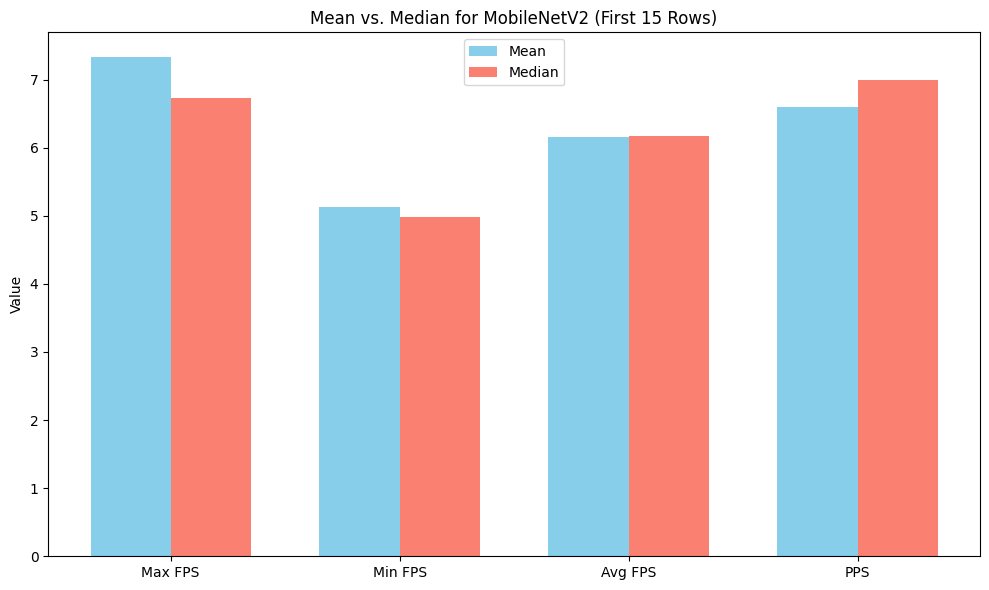

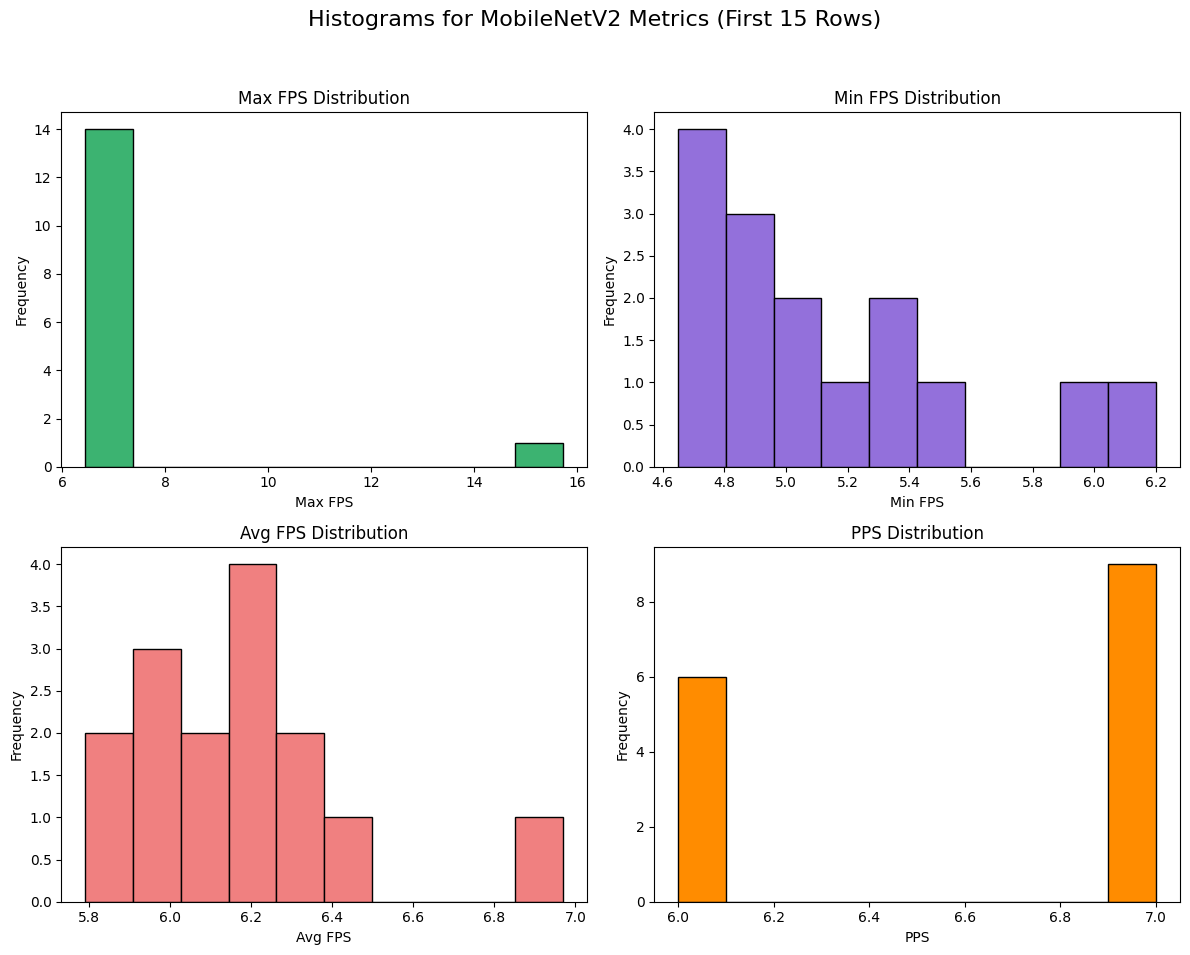

Model: MobileNet
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 6.4GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 6.51, Median Max FPS: 6.49
Mean Min FPS: 4.80, Median Min FPS: 4.86
Mean Avg FPS: 5.89, Median Avg FPS: 5.90
Mean PPS: 6.27, Median PPS: 6.00


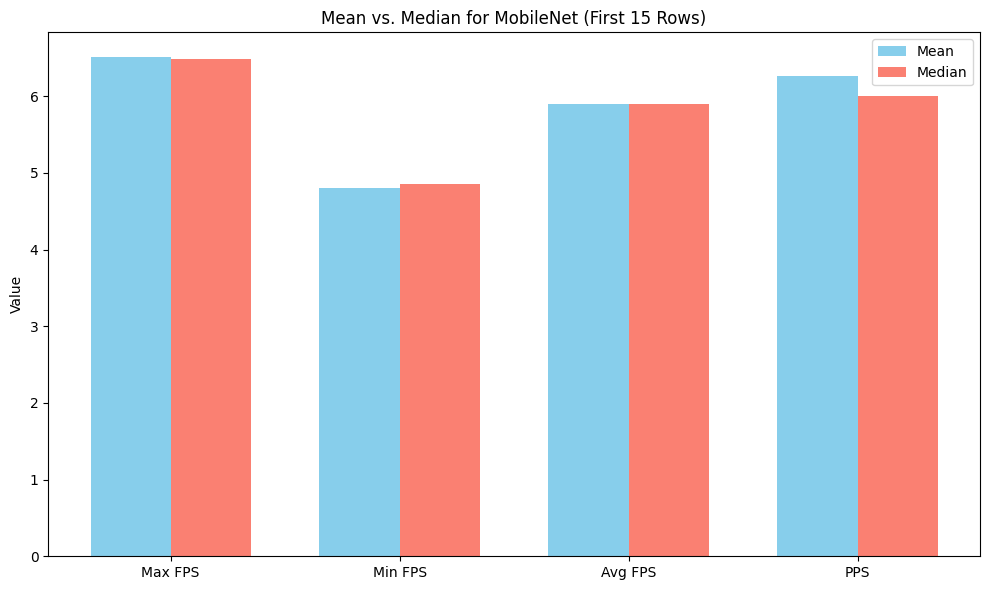

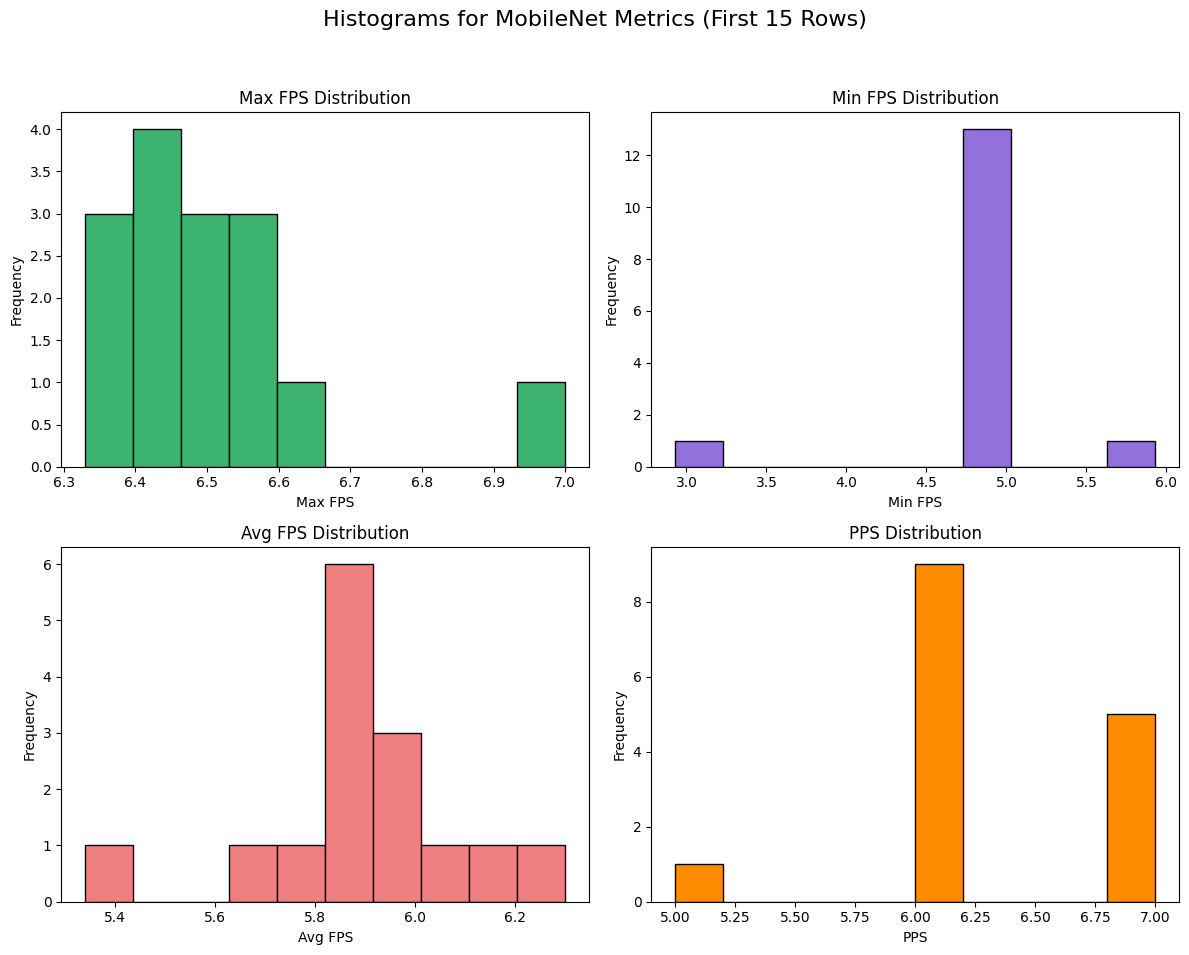

Model: VGG16
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 5.9GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 5.32, Median Max FPS: 4.58
Mean Min FPS: 3.85, Median Min FPS: 4.05
Mean Avg FPS: 4.47, Median Avg FPS: 4.40
Mean PPS: 4.93, Median PPS: 5.00


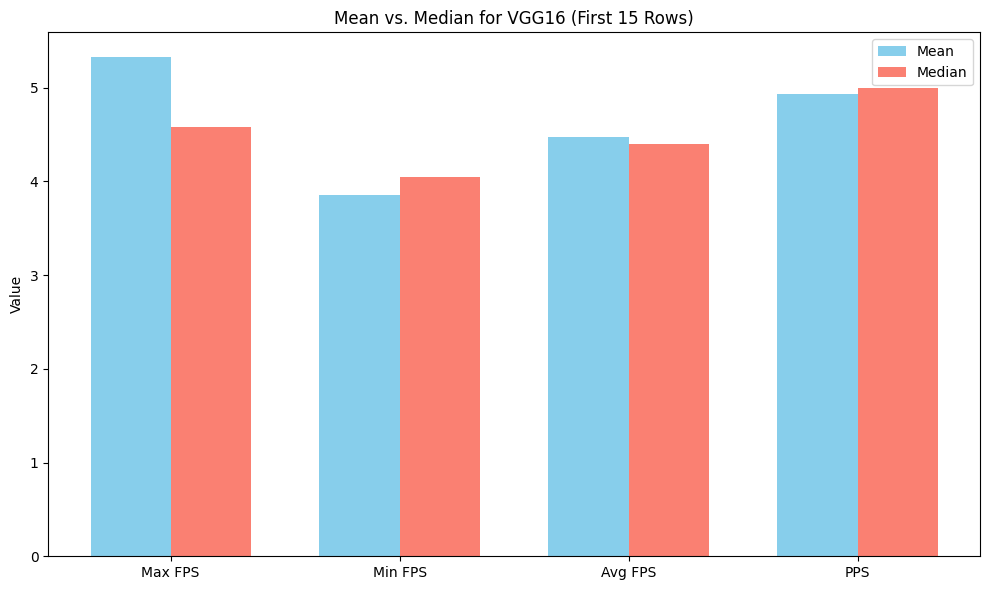

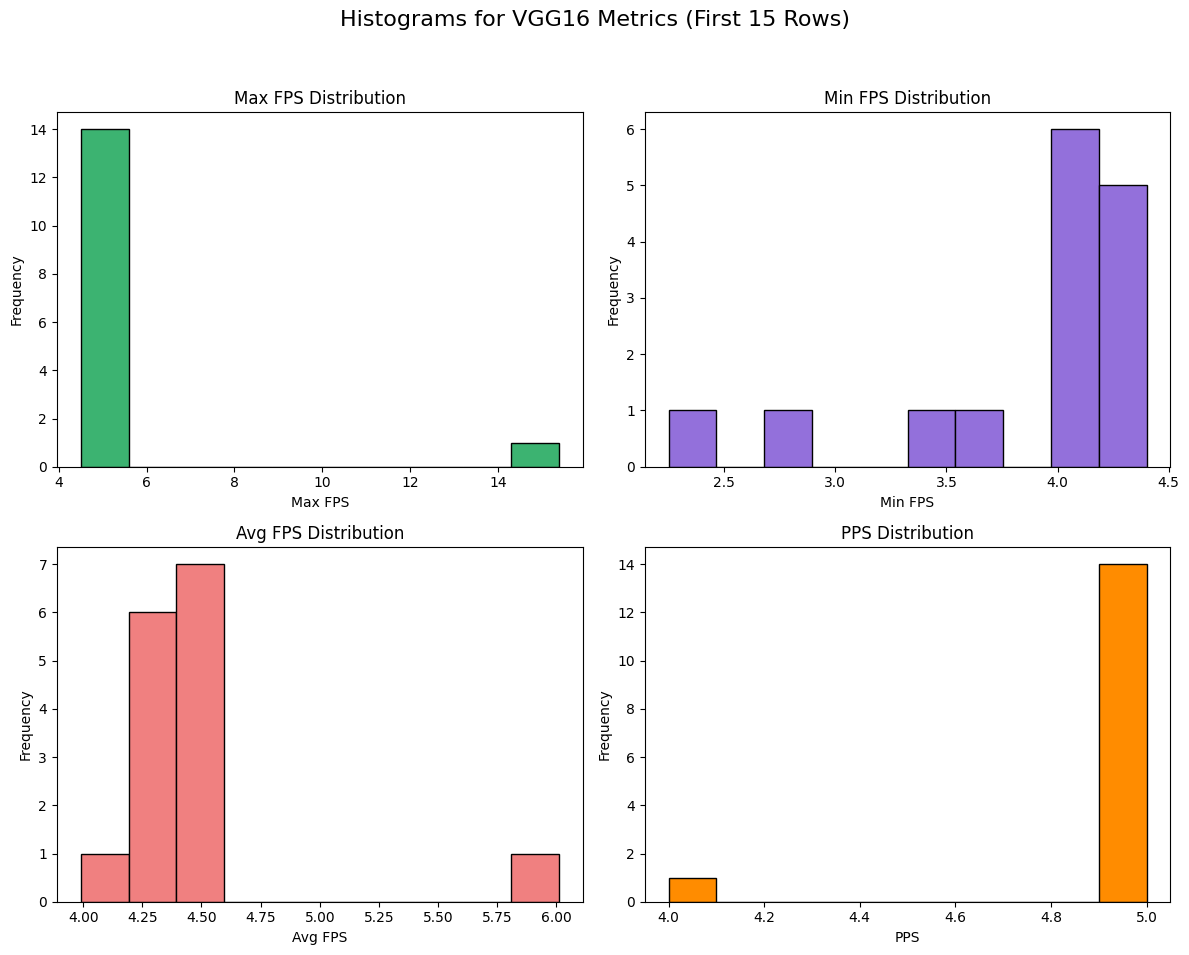

Model: VGG19
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 5.8GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 4.94, Median Max FPS: 4.01
Mean Min FPS: 3.44, Median Min FPS: 3.47
Mean Avg FPS: 3.91, Median Avg FPS: 3.73
Mean PPS: 4.07, Median PPS: 4.00


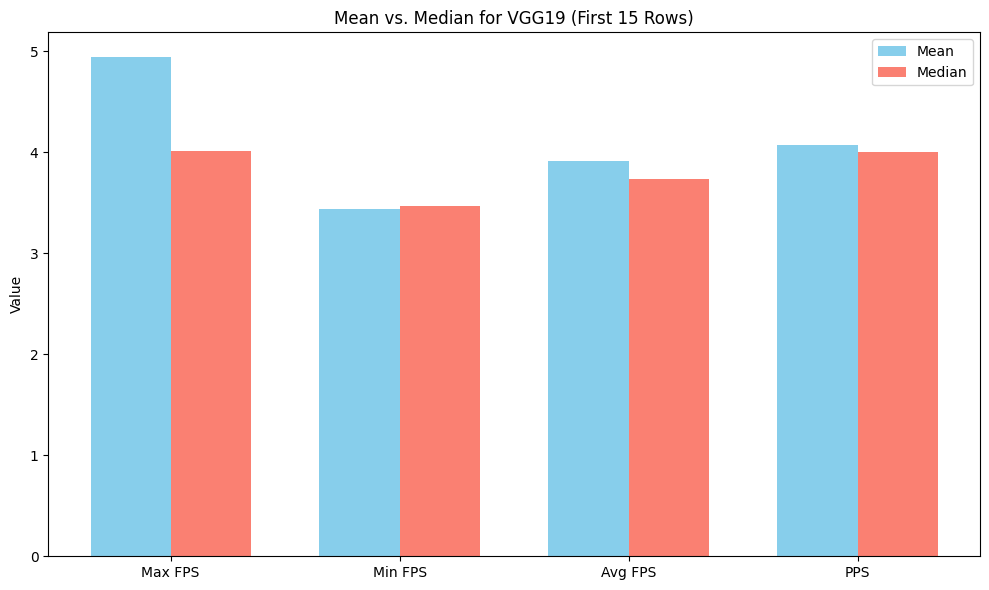

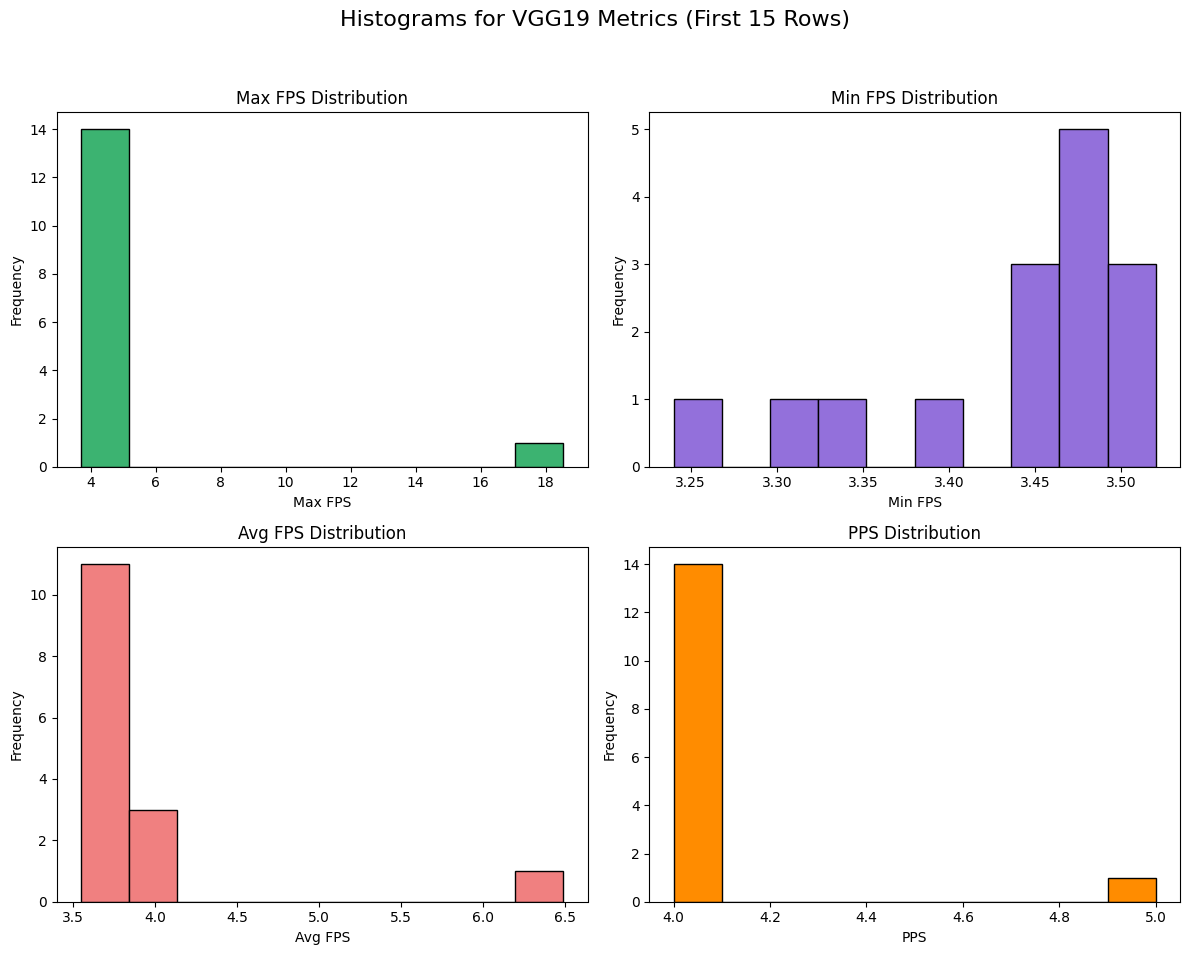

Model: NasNetMobile
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 5.9GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 5.56, Median Max FPS: 5.38
Mean Min FPS: 4.09, Median Min FPS: 4.54
Mean Avg FPS: 4.74, Median Avg FPS: 5.17
Mean PPS: 5.33, Median PPS: 6.00


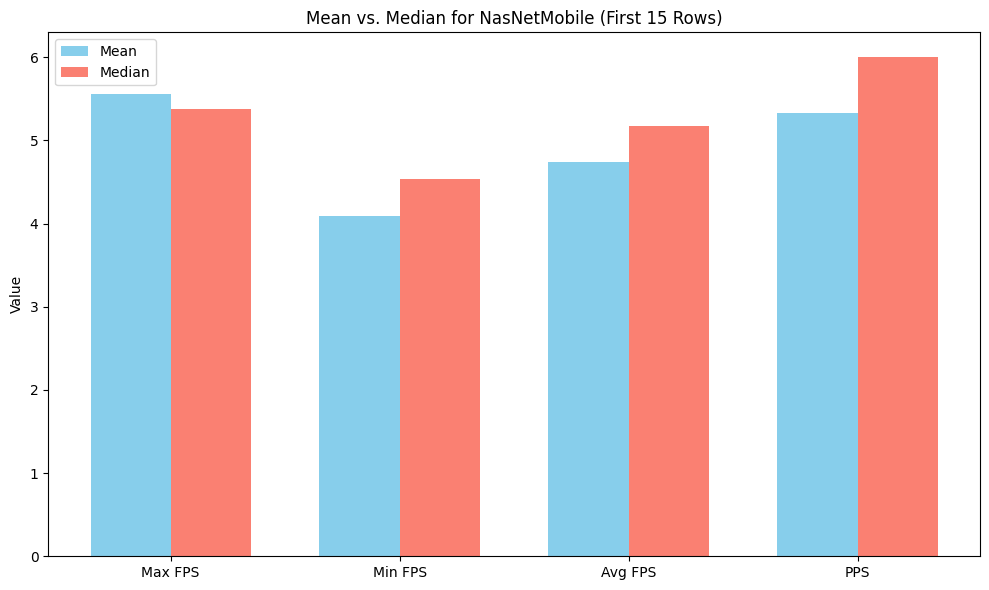

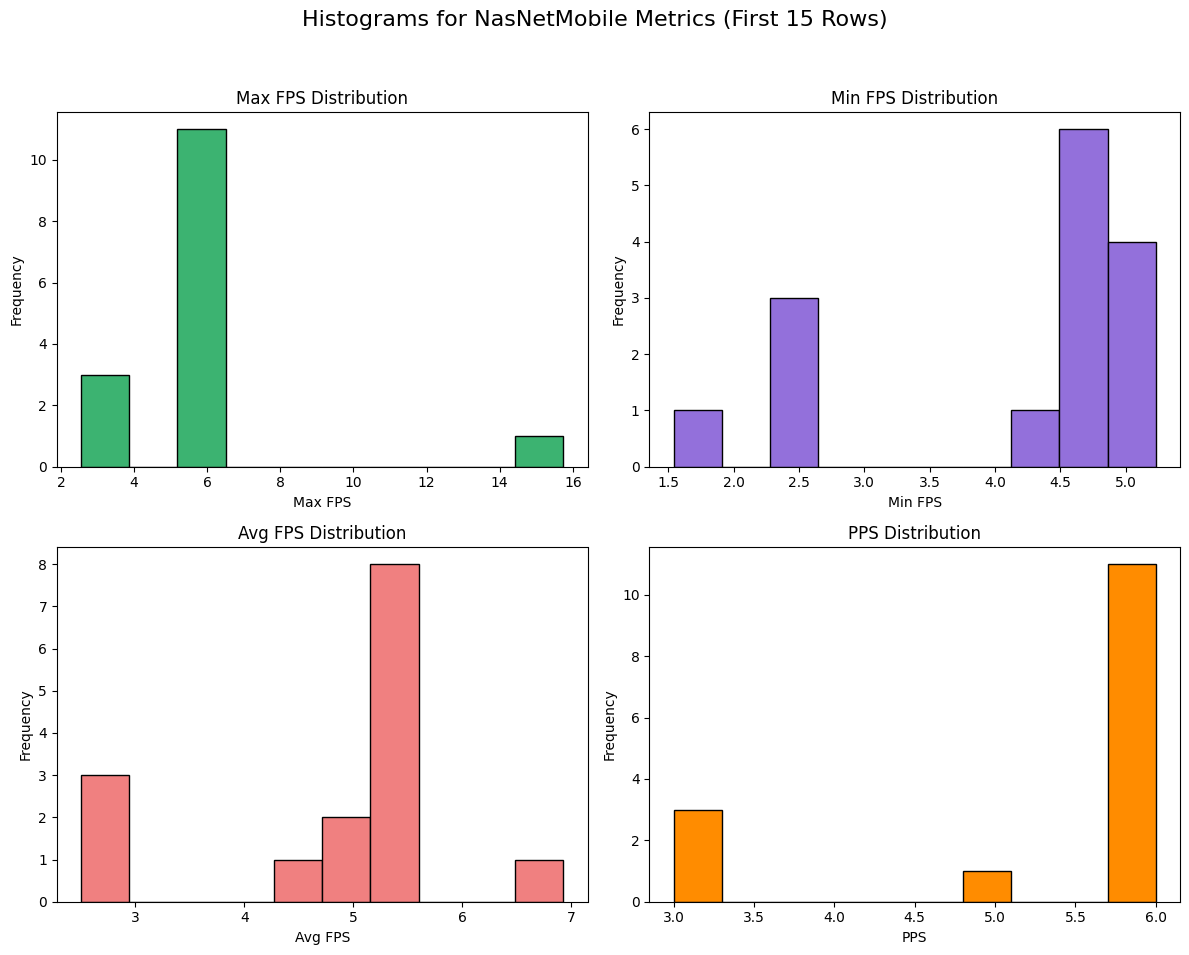

Model: DenseNet121
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 6.0GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 5.59, Median Max FPS: 5.76
Mean Min FPS: 4.65, Median Min FPS: 4.70
Mean Avg FPS: 5.10, Median Avg FPS: 5.12
Mean PPS: 5.67, Median PPS: 6.00


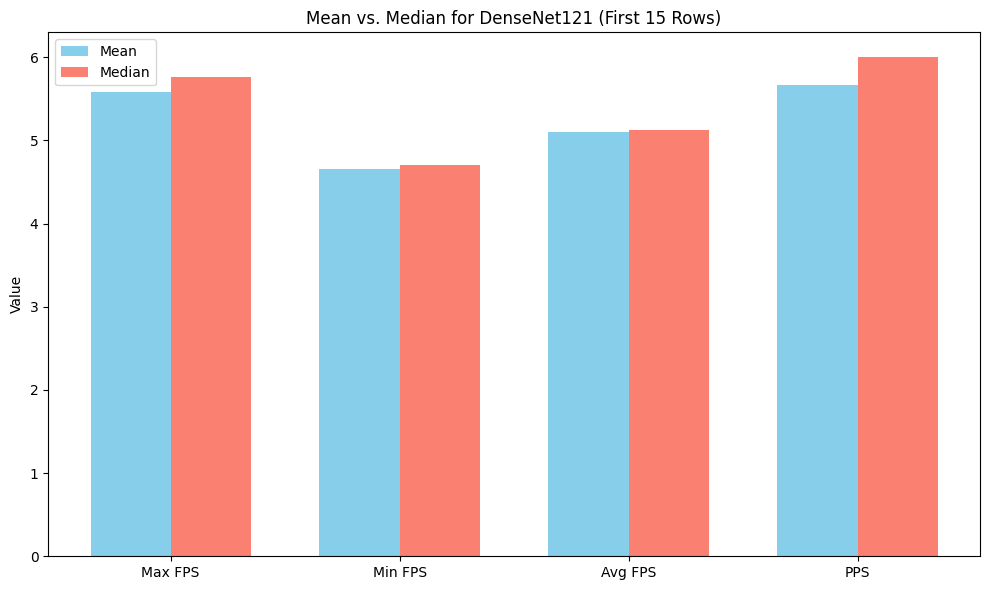

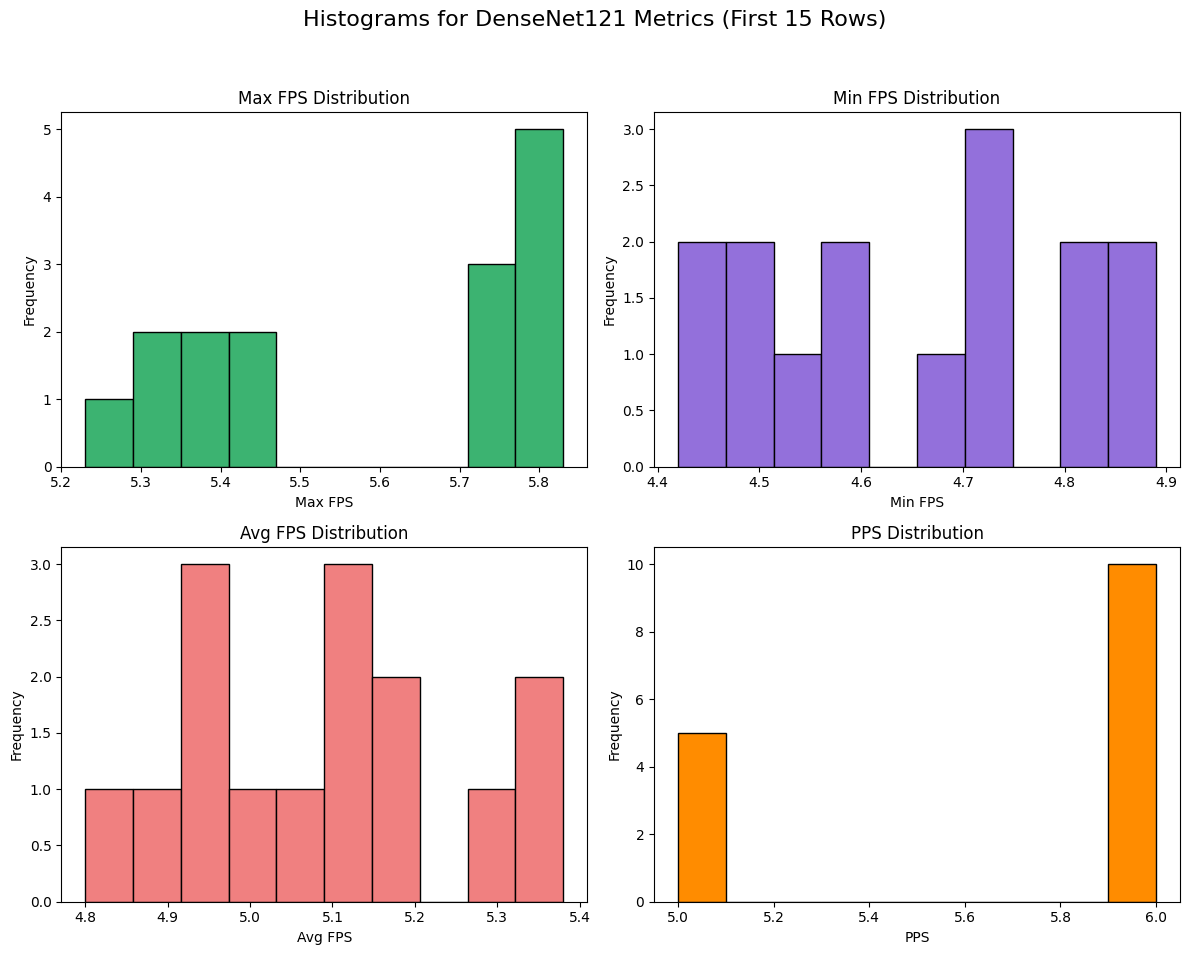

Model: VGG16+MobileNetV2 Fusion Model
Device Info:
  CPU: CPU: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel (20 cores)
  GPU: GPU: Not available
  Memory: Memory: 5.6GB free / 15.6GB total
Rows considered: 15
Mean Max FPS: 4.88, Median Max FPS: 4.27
Mean Min FPS: 3.12, Median Min FPS: 3.36
Mean Avg FPS: 3.80, Median Avg FPS: 3.91
Mean PPS: 3.93, Median PPS: 4.00


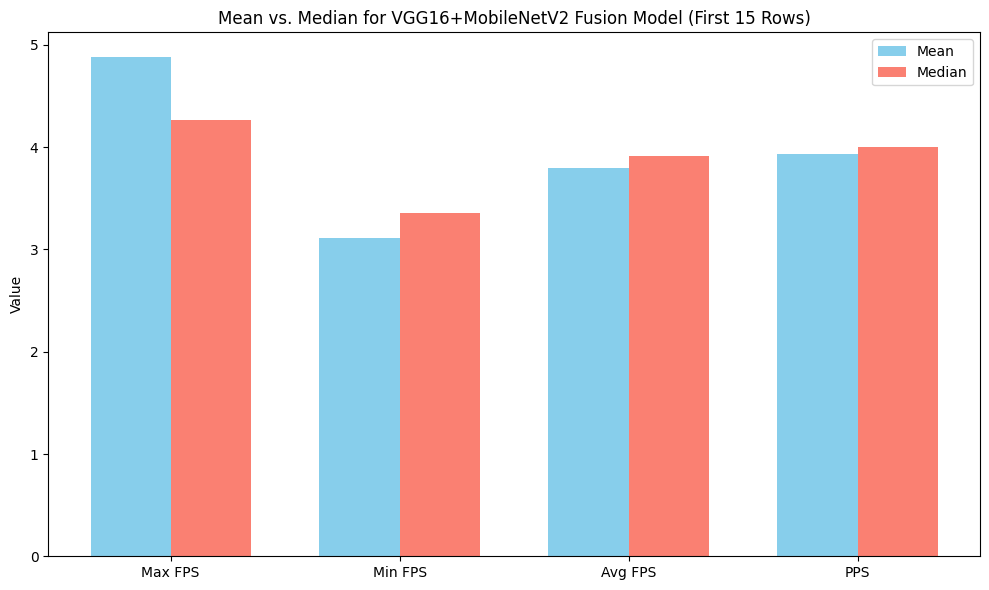

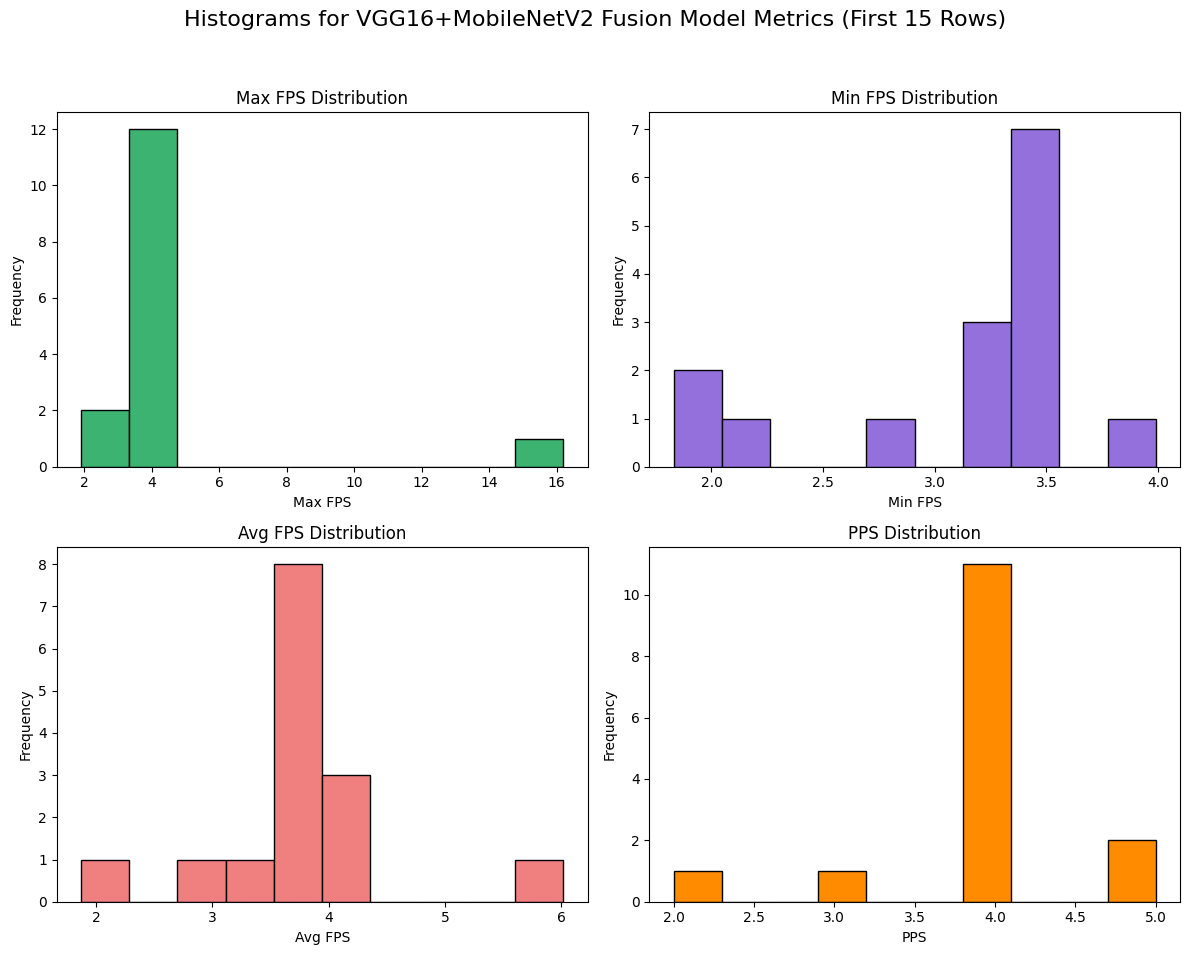

Summary of Performance Metrics by Model:


,Model,Mean Max FPS,Median Max FPS,Mean Min FPS,Median Min FPS,Mean Avg FPS,Median Avg FPS,Mean PPS,Median PPS
0,MobileNetV2,7.326667,6.73,5.130667,4.98,6.162000,6.17,6.600000,7.0
1,MobileNet,6.508000,6.49,4.802667,4.86,5.893333,5.90,6.266667,6.0
2,VGG16,5.324000,4.58,3.849333,4.05,4.468667,4.40,4.933333,5.0
3,VGG19,4.938667,4.01,3.440667,3.47,3.909333,3.73,4.066667,4.0
4,NasNetMobile,5.558000,5.38,4.092000,4.54,4.738000,5.17,5.333333,6.0
5,DenseNet121,5.585333,5.76,4.654667,4.70,5.096667,5.12,5.666667,6.0
6,VGG16+MobileNetV2 Fusion Model,4.879333,4.27,3.116000,3.36,3.801333,3.91,3.933333,4.0



Percentage Difference Relative to the Best Model:

Metric: Mean Max FPS
  MobileNetV2 is the best with a value of 7.33.
  MobileNet is 11.17% less efficient than MobileNetV2 (value: 6.51 vs 7.33).
  VGG16 is 27.33% less efficient than MobileNetV2 (value: 5.32 vs 7.33).
  VGG19 is 32.59% less efficient than MobileNetV2 (value: 4.94 vs 7.33).
  NasNetMobile is 24.14% less efficient than MobileNetV2 (value: 5.56 vs 7.33).
  DenseNet121 is 23.77% less efficient than MobileNetV2 (value: 5.59 vs 7.33).
  VGG16+MobileNetV2 Fusion Model is 33.40% less efficient than MobileNetV2 (value: 4.88 vs 7.33).

Metric: Mean Min FPS
  MobileNetV2 is the best with a value of 5.13.
  MobileNet is 6.39% less efficient than MobileNetV2 (value: 4.80 vs 5.13).
  VGG16 is 24.97% less efficient than MobileNetV2 (value: 3.85 vs 5.13).
  VGG19 is 32.94% less efficient than MobileNetV2 (value: 3.44 vs 5.13).
  NasNetMobile is 20.24% less efficient than MobileNetV2 (value: 4.09 vs 5.13).
  DenseNet121 is 9.28% less

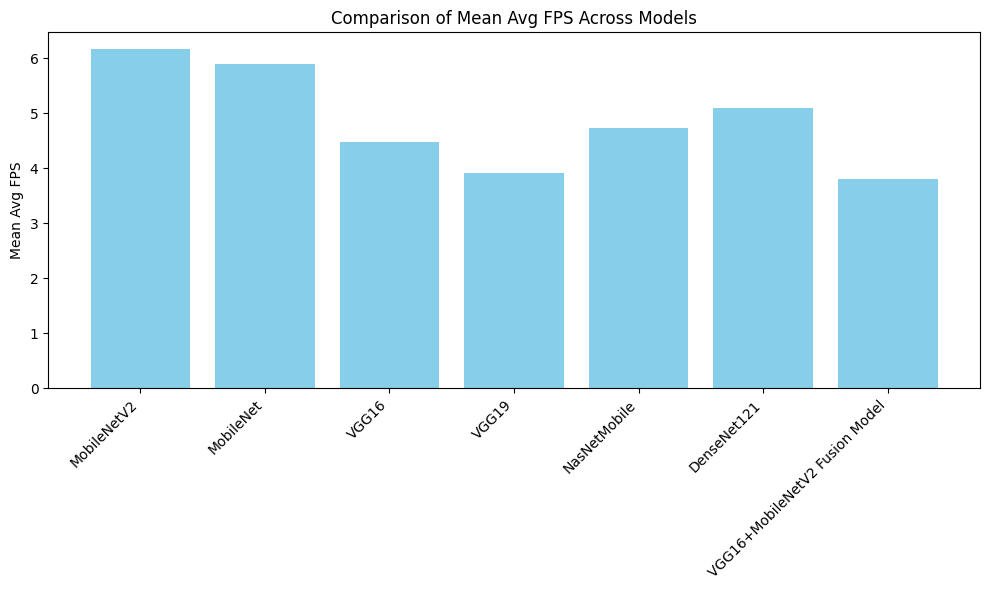

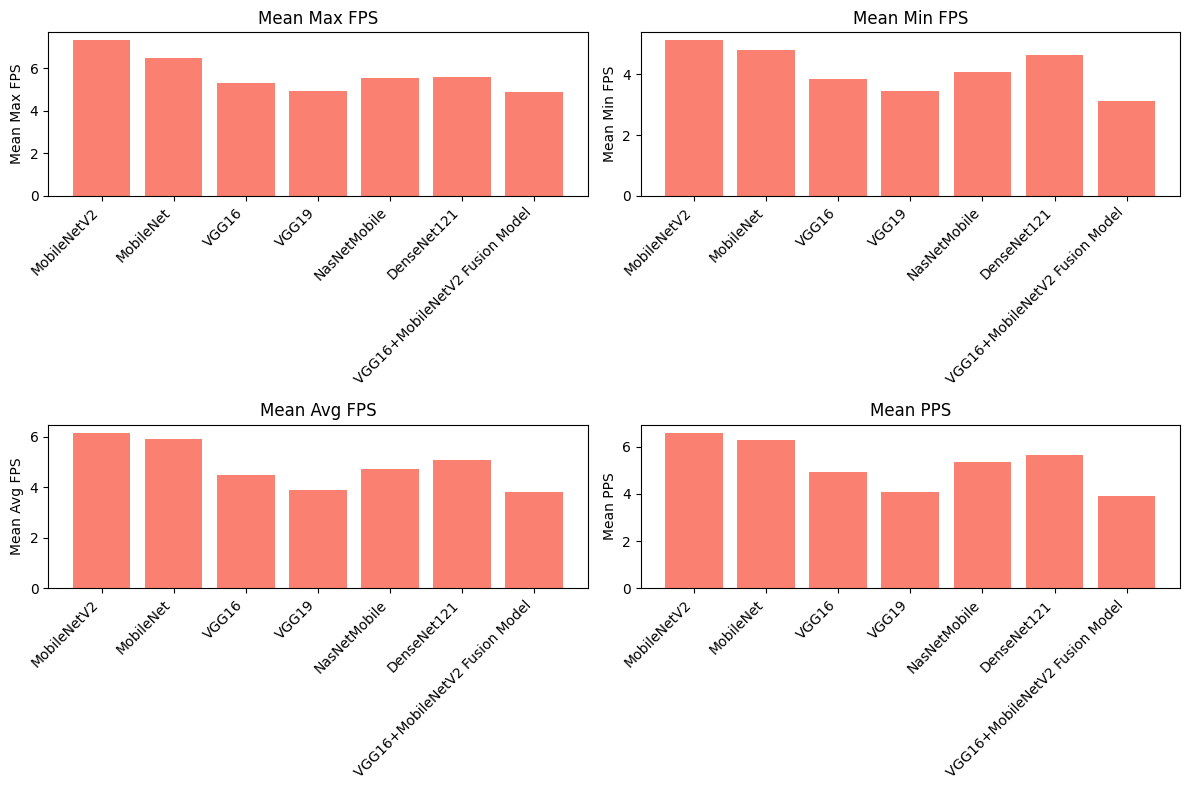

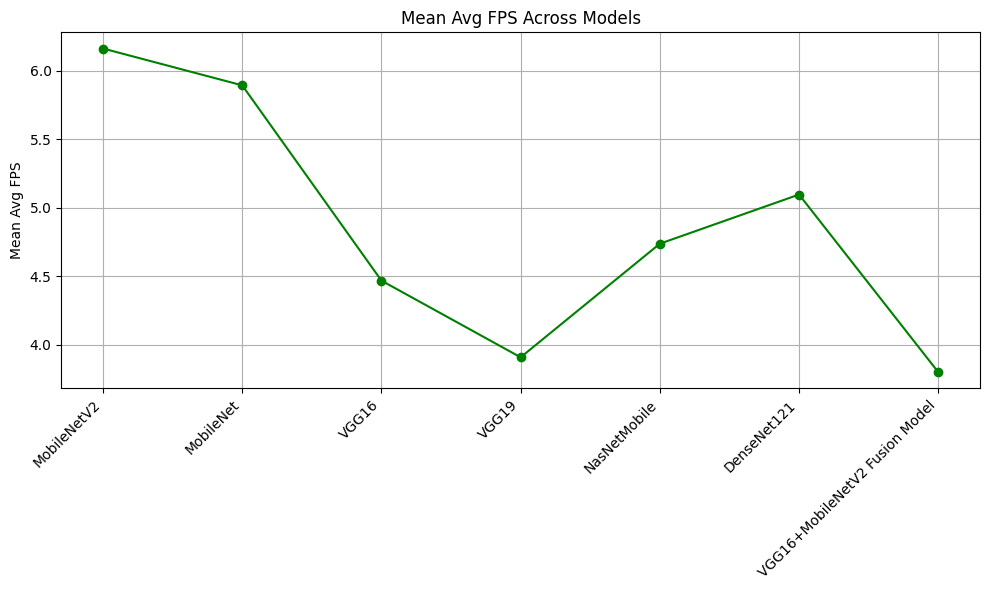

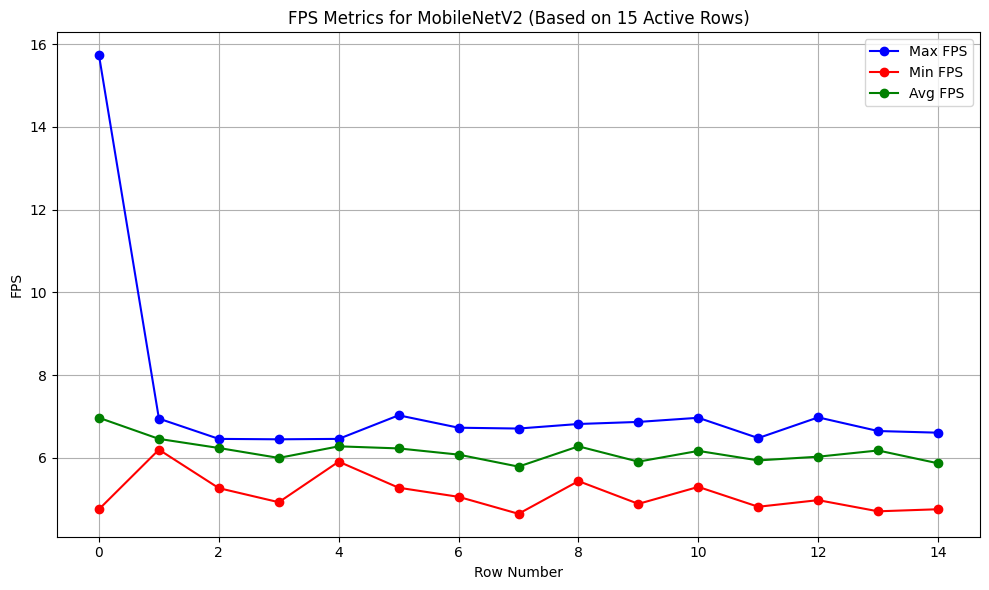

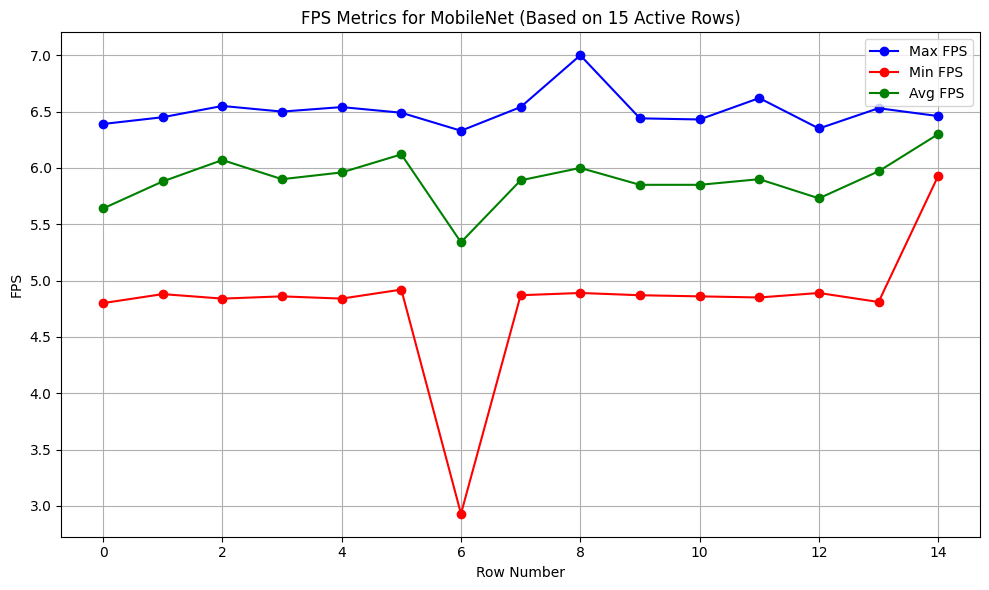

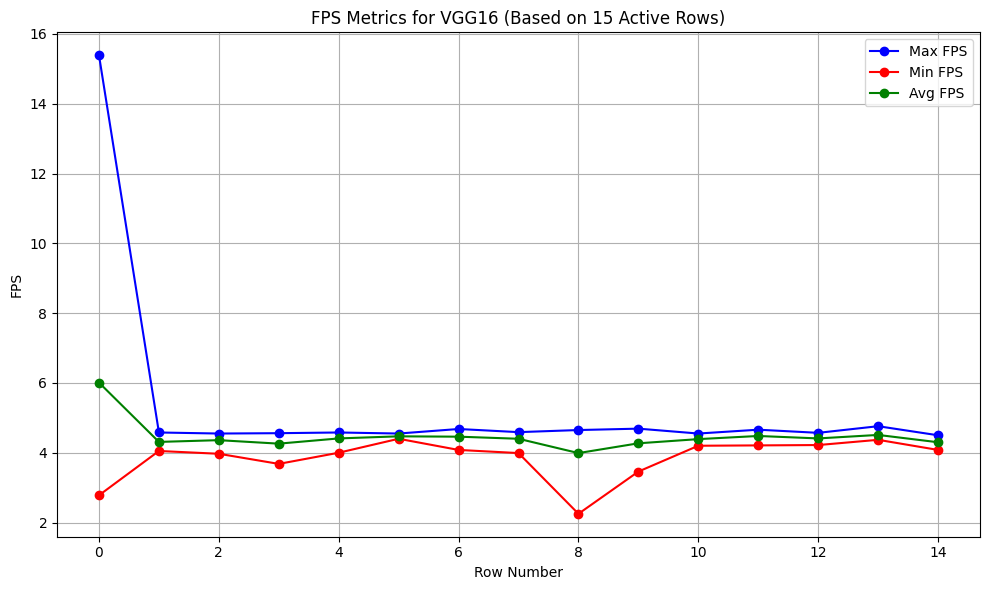

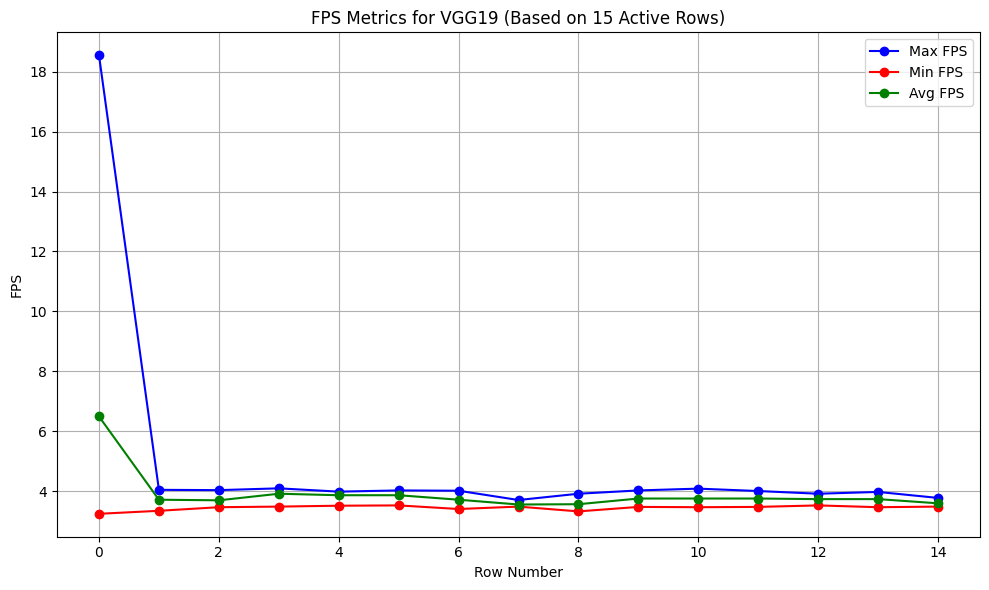

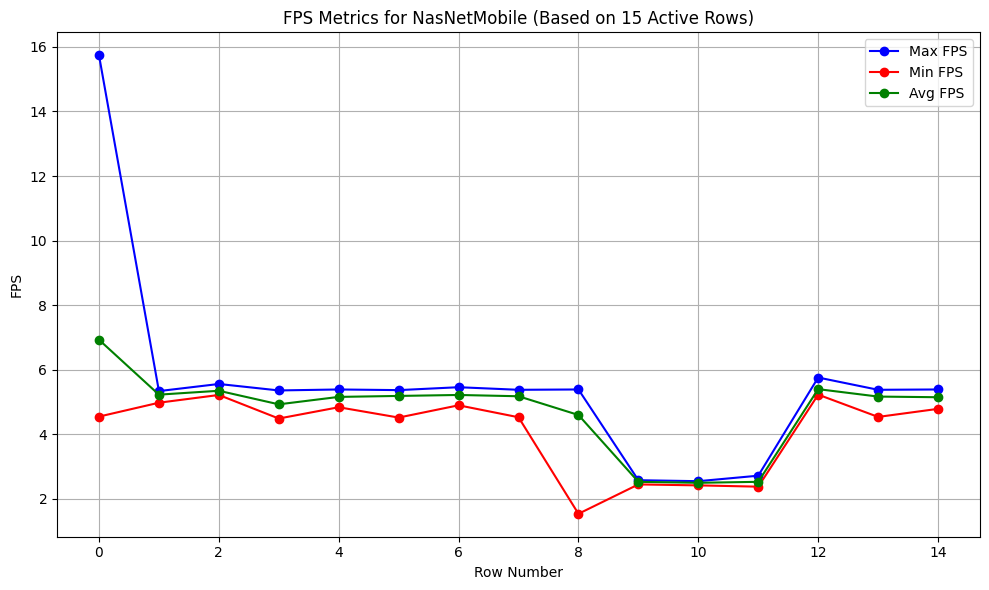

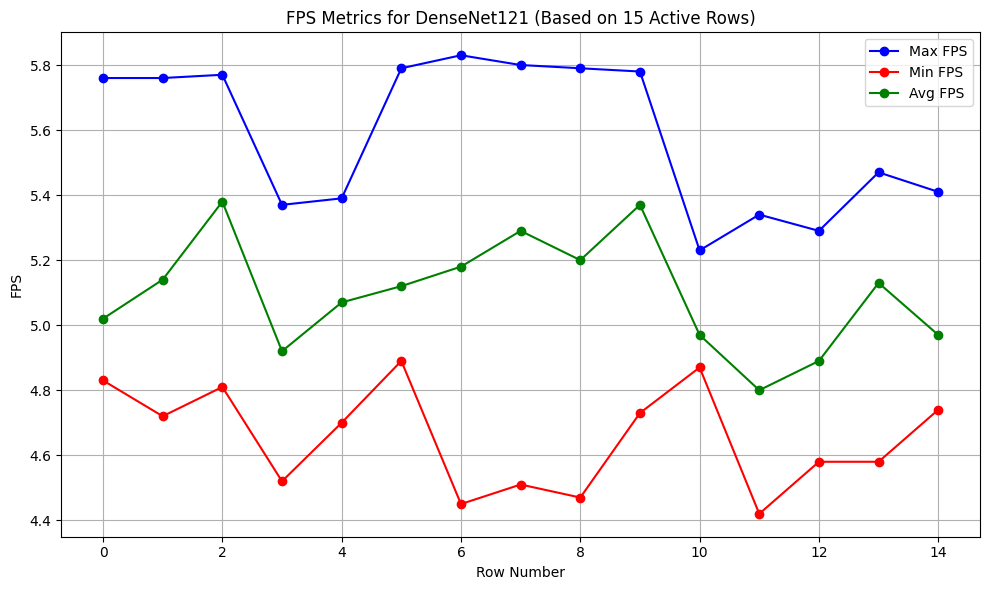

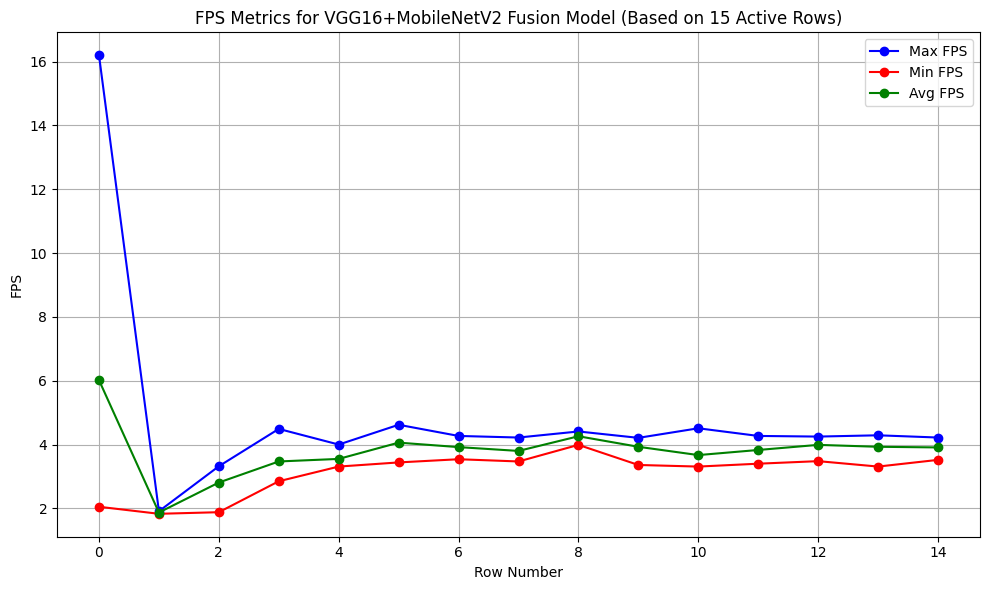

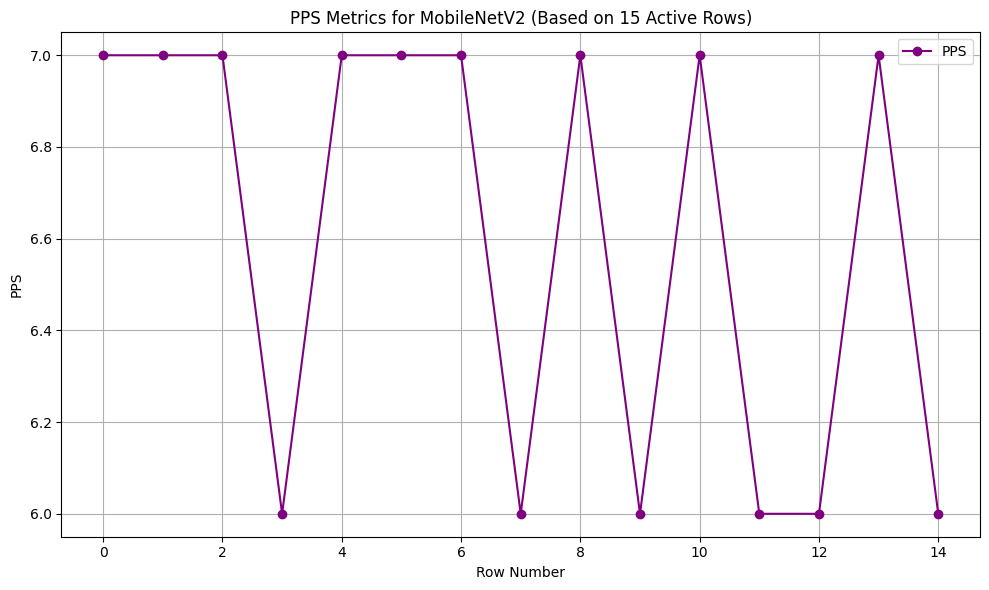

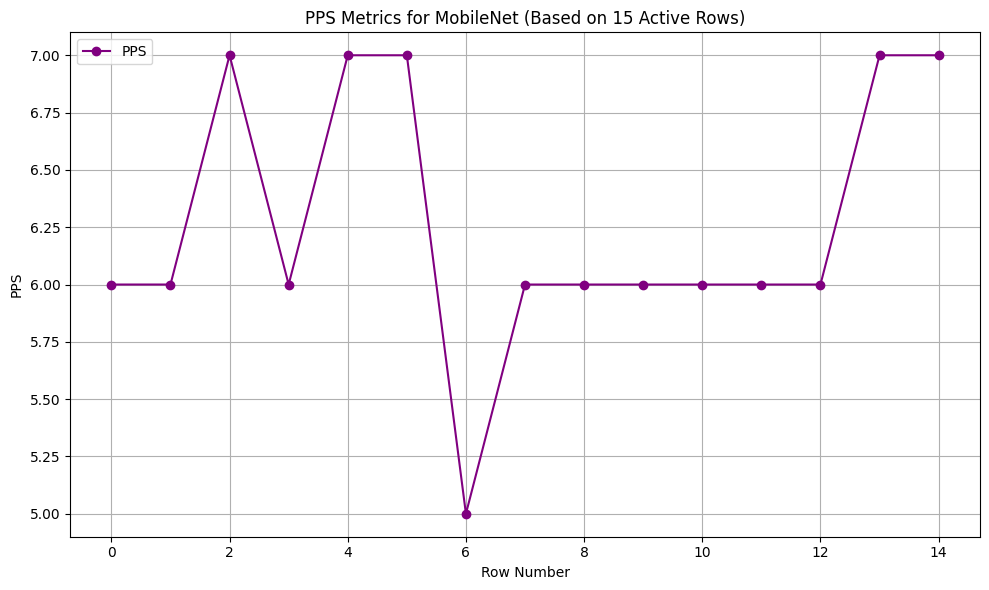

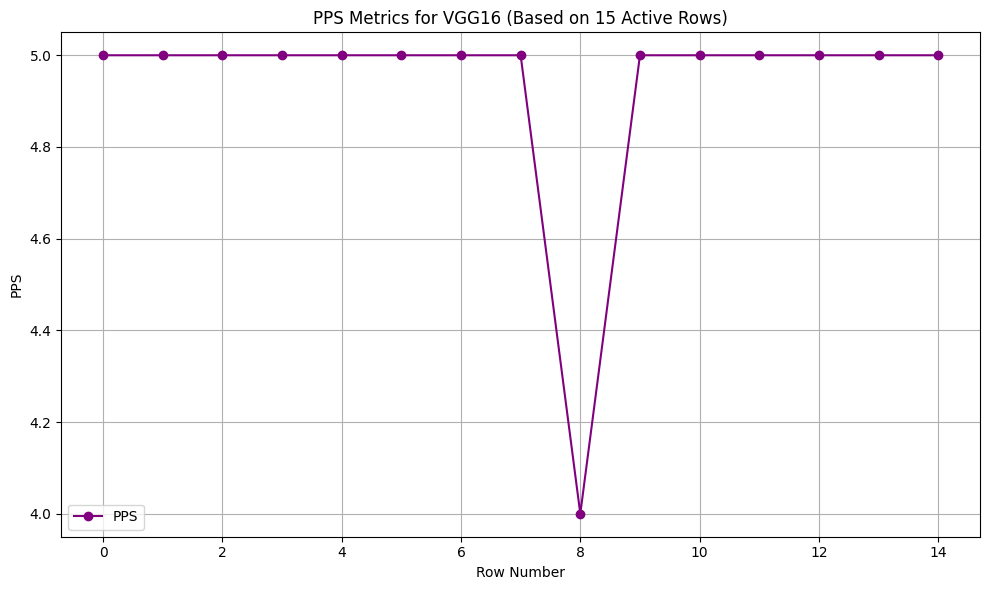

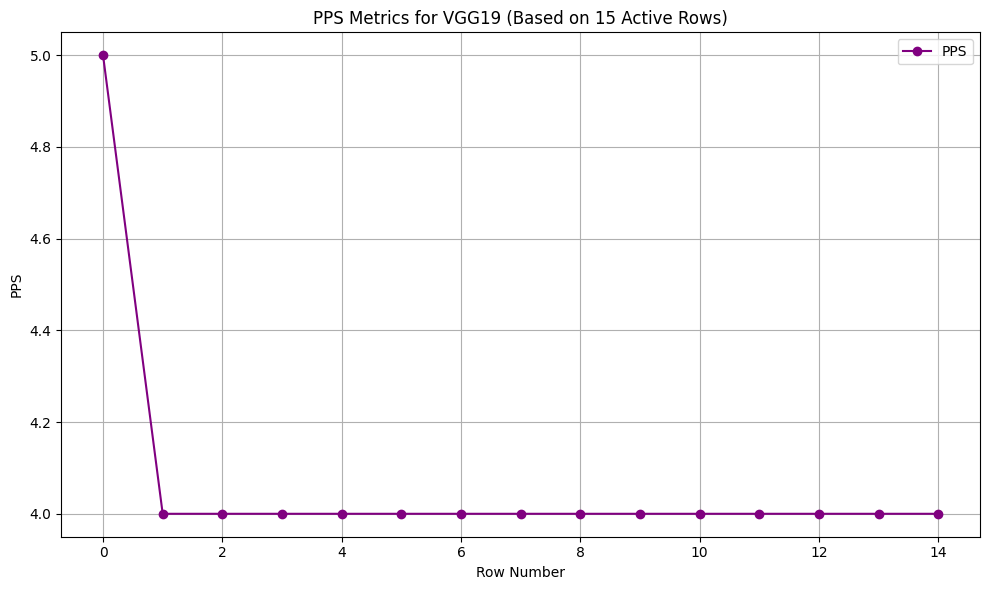

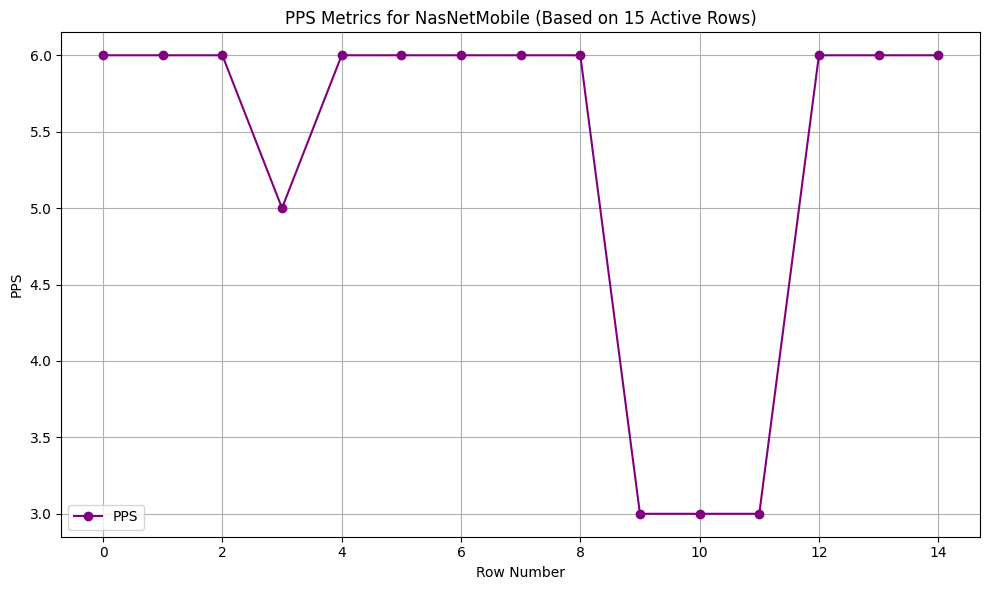

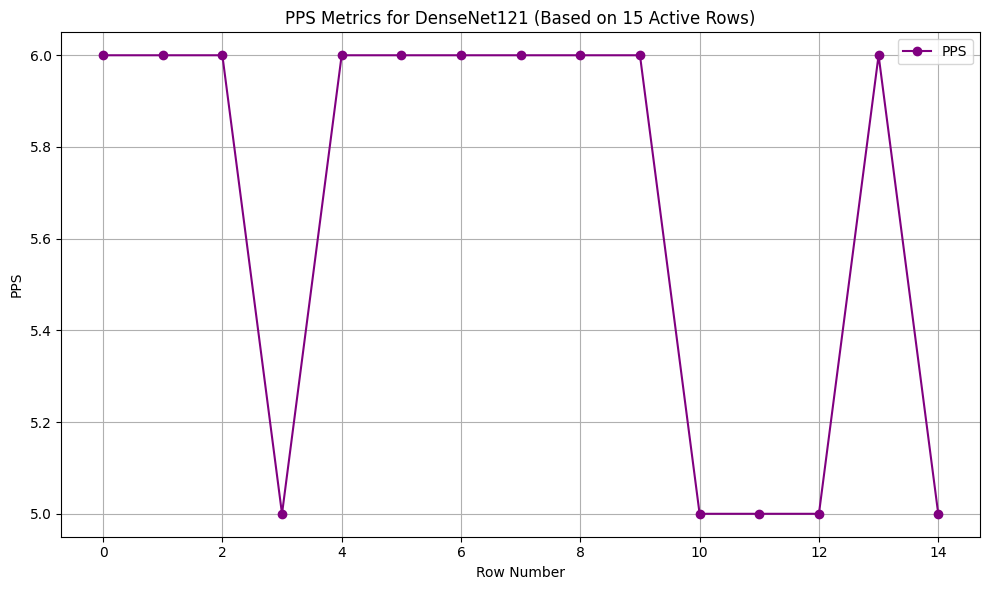

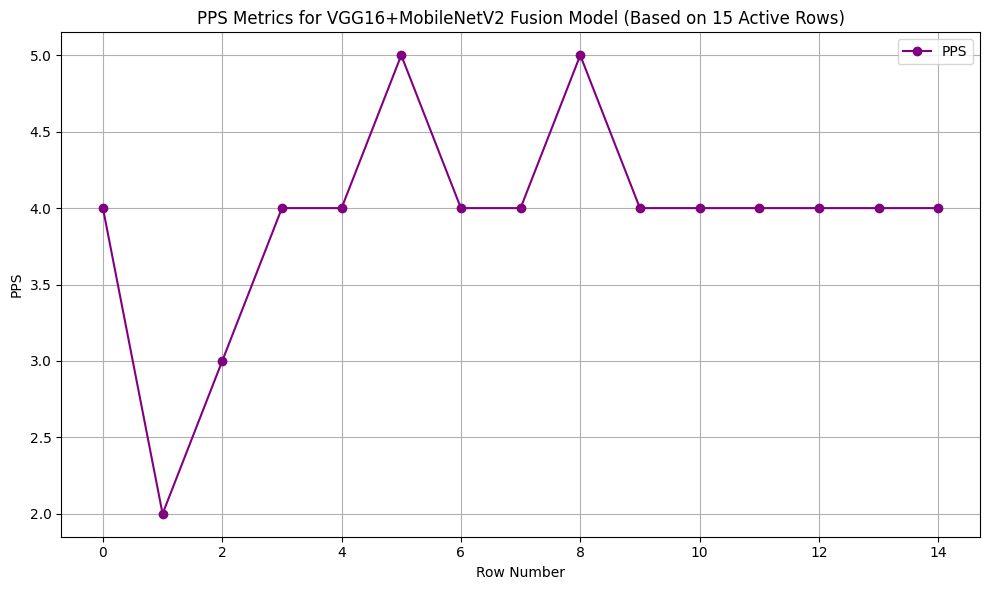

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Process results for all models (update file paths as needed)
results = []
results.append(process_results_file("AppFPS_Results\\MobileNetV2 (T2)_results.txt", "MobileNetV2"))
results.append(process_results_file("AppFPS_Results\\MobileNet (T2)_results.txt", "MobileNet"))
results.append(process_results_file("AppFPS_Results\\VGG16 (T2)_results.txt", "VGG16"))
results.append(process_results_file("AppFPS_Results\\VGG19 (T2)_results.txt", "VGG19"))
results.append(process_results_file("AppFPS_Results\\NasNetMobile (T2)_results.txt", "NasNetMobile"))
results.append(process_results_file("AppFPS_Results\\DenseNet121 (T2)_results.txt", "DenseNet121"))
results.append(process_results_file("AppFPS_Results\\Fusion Model (T2)_results.txt", "VGG16+MobileNetV2 Fusion Model"))


# Build a summary table
summary_data = {
    "Model": [r["model"] for r in results],
    "Mean Max FPS": [r["mean_max_fps"] for r in results],
    "Median Max FPS": [r["median_max_fps"] for r in results],
    "Mean Min FPS": [r["mean_min_fps"] for r in results],
    "Median Min FPS": [r["median_min_fps"] for r in results],
    "Mean Avg FPS": [r["mean_avg_fps"] for r in results],
    "Median Avg FPS": [r["median_avg_fps"] for r in results],
    "Mean PPS": [r["mean_pps"] for r in results],
    "Median PPS": [r["median_pps"] for r in results]
}

df_summary = pd.DataFrame(summary_data)
print("Summary of Performance Metrics by Model:")
display(df_summary)

# Determine the most efficient model based on Mean Avg FPS
best_model = df_summary.loc[df_summary["Mean Avg FPS"].idxmax()]
metrics = ["Mean Max FPS", "Mean Min FPS", "Mean Avg FPS", "Mean PPS"]

print("\nPercentage Difference Relative to the Best Model:\n")
for metric in metrics:
    best_value = best_model[metric]
    print(f"Metric: {metric}")
    for index, row in df_summary.iterrows():
        model_name = row["Model"]
        model_value = row[metric]
        if model_name == best_model["Model"]:
            print(f"  {model_name} is the best with a value of {model_value:.2f}.")
        else:
            # Calculate percentage difference relative to best_value
            diff_percent = ((best_value - model_value) / best_value) * 100
            if diff_percent > 0:
                print(f"  {model_name} is {diff_percent:.2f}% less efficient than {best_model['Model']} (value: {model_value:.2f} vs {best_value:.2f}).")
            elif diff_percent < 0:
                print(f"  {model_name} is {abs(diff_percent):.2f}% more efficient than {best_model['Model']} (value: {model_value:.2f} vs {best_value:.2f}).")
            else:
                print(f"  {model_name} is equal in efficiency to {best_model['Model']} (value: {model_value:.2f}).")
    print()


# ----- Comparison Plots -----

# Bar chart comparing Mean Avg FPS across models
plt.figure(figsize=(10,6))
plt.bar(df_summary["Model"], df_summary["Mean Avg FPS"], color="skyblue")
plt.ylabel("Mean Avg FPS")
plt.title("Comparison of Mean Avg FPS Across Models")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Grouped bar charts for each metric across models
metrics_to_plot = ["Mean Max FPS", "Mean Min FPS", "Mean Avg FPS", "Mean PPS"]
plt.figure(figsize=(12,8))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2,2,i+1)
    plt.bar(df_summary["Model"], df_summary[metric], color="salmon")
    plt.title(metric)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

# Draw a line plot for Mean Avg FPS across models
plt.figure(figsize=(10,6))
plt.plot(df_summary["Model"], df_summary["Mean Avg FPS"], marker="o", color="green")
plt.title("Mean Avg FPS Across Models")
plt.ylabel("Mean Avg FPS")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Draw a line plot for Max, Min and Avg FPS in a model thru the 15 rows (iterating over models)
for i, model in enumerate(results):
    plt.figure(figsize=(10,6))
    plt.plot(results[i]["max_fps_list"], marker="o", label="Max FPS", color="blue")
    plt.plot(results[i]["min_fps_list"], marker="o", label="Min FPS", color="red")
    plt.plot(results[i]["avg_fps_list"], marker="o", label="Avg FPS", color="green")
    plt.title(f"FPS Metrics for {model['model']} (Based on 15 Active Rows)")
    plt.xlabel("Row Number")
    plt.ylabel("FPS")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Draw a line plot for PPS in a model thru the 15 rows
for i, model in enumerate(results):
    plt.figure(figsize=(10,6))
    plt.plot(results[i]["pps_list"], marker="o", label="PPS", color="purple")
    plt.title(f"PPS Metrics for {model['model']} (Based on 15 Active Rows)")
    plt.xlabel("Row Number")
    plt.ylabel("PPS")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
